In [1]:
import pandas as pd
import json
import os
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [3]:
#OLS analysis
from sklearn import linear_model
import statsmodels.api as sm

In [4]:
from scipy.stats import mannwhitneyu
from scipy import stats

In [5]:
import statsmodels.stats.multitest as multi

In [6]:
with open('/cellar/users/mpagadal/resources/tcga/ensembl_map.json', 'r') as f:
    ensembl = json.load(f)
ensembl={k.split(".")[0]:v for k,v in ensembl.items()}

In [7]:
with open('/cellar/controlled/dbgap-genetic/ICB/rna/TPMs/all_immunotherapy_tpm.json', 'r') as f:
    icb_tpm = json.load(f)
tpm=pd.DataFrame.from_dict(icb_tpm)

In [8]:
def fdr(df,pseudo,p):
    
    '''
    calculate Benjamini-Hochberg FDR
    pseudo: True or False
    '''
    
    #add pseudocounta
    if pseudo == True:
        df[p]=df[p]+0.000000000001
    
    #calculate benjamin-hochberg fdr
    probabilities = df[p].to_numpy()
    report = multi.multipletests(probabilities,
                alpha=0.05,
                method="fdr_bh",
                is_sorted=False,
            )
    discoveries = report[1]
    df["fdr"]=discoveries
    df["fdr"]=pd.to_numeric(df["fdr"])
    df["-log10(fdr)"]=-np.log10(df["fdr"])
    
    return(df)

### Get PD-1/PD-L1

In [9]:
#analyze TPM rna
rna=tpm.copy()
rna+=1
rna=np.log2(rna)
rna.index=rna.index.str.split(".").str[0]
rna["gene name"]=rna.index.map(ensembl)
rna=rna[~(rna["gene name"].isnull())]
rna.index=rna["gene name"]
del rna["gene name"]
rna=rna.T
rna.index=rna.index.str.split(".sra").str[0]
rna=rna.reset_index()
rna=rna.rename(columns={"index":"FID"})

In [10]:
#get mapping file
mapping=pd.read_csv("/cellar/users/mpagadal/immunotherapy-trials/data/wxs_rna_mapping_table_v2.tsv",delimiter="\t")
print(len(mapping["normal WXS id"].unique()))
mapping=mapping[~(mapping["tumor RNA id"].isnull())]

742


In [11]:
mp_study=dict(zip(mapping["tumor RNA id"],mapping["study"]))
mp_time=dict(zip(mapping["tumor RNA id"],mapping["Biopsy Time"]))
mp_response=dict(zip(mapping["normal WXS id"],mapping["Response"]))
mp_rna2geno=dict(zip(mapping["tumor RNA id"],mapping["normal WXS id"]))

mp_tmr2geno={}
for i,row in mapping.iterrows():
    for x in row["tumor WXS id"].split(", "):
        mp_tmr2geno[x]=row["normal WXS id"]

In [12]:
rna["study"]=rna["FID"].map(mp_study)
rna["time"]=rna["FID"].map(mp_time)

rna["FID"]=rna["FID"].map(mp_rna2geno)
rna_filt=rna[~(rna["FID"].isnull())]

rna_filt["response"]=rna_filt["FID"].map(mp_response)

dict_response={"Progressive Disease":"PD","Partial Response":"PR","Complete Response":"CR"}
rna_filt=rna_filt.replace({"response": dict_response})
rna_filt_pre=rna_filt[~rna_filt["time"].isin(["On","on-treatment"])]

/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [13]:
ic_exp=rna_filt_pre[["FID","PDCD1","CD274","CTLA4"]]

### Get TMB

In [14]:
tmb=pd.read_csv("/cellar/users/mpagadal/immunotherapy-trials/data/tmb/mutect.filtered.muts.tsv",delimiter="\t")
tmb=tmb[["tumor_id"]].groupby(["tumor_id"]).size().reset_index()
tmb.columns=["tumor_id","TMB"]
tmb["FID"]=tmb["tumor_id"].map(mp_tmr2geno)
tmb=tmb[~tmb["FID"].isnull()]
tmb=tmb[["FID","TMB"]].groupby(["FID"]).mean().reset_index()

In [15]:
compiled_prs=pd.read_csv("../data/icb-response/burden-score/burden.fdr.5.csv")
compiled_prs=compiled_prs[["FID","pheno","study"]]

### Get covariate

In [16]:
cov=pd.read_csv("/cellar/controlled/dbgap-genetic/ICB/covar/total.cov.age.sex.study.v2.txt",delimiter="\t")

### Combine

In [17]:
markers=pd.merge(ic_exp,tmb[["FID","TMB"]],on="FID",how="left")
markers=pd.merge(markers,compiled_prs,on="FID",how="outer")
markers=pd.merge(markers,cov,on=["FID"])
markers=markers[~markers["study"].isnull()]

In [18]:
markers["response"]=markers["pheno"].map({2:1,1:0})

### Run OLS with markers

In [19]:
beta=[]
pval=[]
marker_lst=[]
study_lst=[]

for study in markers["study"].unique():
    
    for marker in ["PDCD1","CD274","CTLA4","TMB"]:
        try:
            markers_study=markers[markers["study"]==study]
            markers_study=markers_study[~markers_study[marker].isnull()]
        
            ols = linear_model.LinearRegression()
            X=markers_study[[marker,"Age","Gender","C1","C2","C3","C4","C5","C6","C7","C8","C9","C10"]]
            y=markers_study["pheno"].values.reshape(-1, 1)
        
            X = sm.add_constant(X)
        
            model=sm.OLS(y,X)
            results=model.fit()
        
            beta.append(results.params[1])
            pval.append(results.pvalues[1])
            marker_lst.append(marker)
            study_lst.append(study)
        except:
            beta.append(0)
            pval.append(0)
            marker_lst.append(marker)
            study_lst.append(study)
            pass

df_ols=pd.DataFrame({"markers":marker_lst,"study":study_lst,"beta":beta,"p":pval})
        

In [20]:
df_ols=df_ols[df_ols["study"].isin(["riaz","miao","vanallen","hugo","rizvi","snyder"])]
df_ols["-log10p"]=-np.log10(df_ols["p"])
df_ols=df_ols.sort_values(by="study")

/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


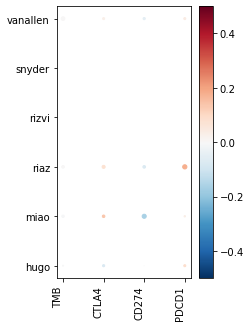

In [60]:
#Plot
def heatmap(x, y, size,color):
    fig, ax = plt.subplots(figsize=(3, 5))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in x.unique()]
    y_labels = [v for v in y.unique()]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 20
    plt.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, 
        c=color,
        cmap="RdBu_r", vmin=-.5, vmax=.5# Vector of square sizes, proportional to size parameter
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    plt.colorbar()
    
    plt.xticks(rotation=90)
    
    
heatmap(
    x=df_ols['markers'],
    y=df_ols['study'],
    size=df_ols['-log10p'],
    color=df_ols['beta'],
)

plt.savefig("../plots/fig5/study.markers.clustermap.pdf")

In [61]:
df_avg=markers[["TMB","CTLA4","CD274","PDCD1","study"]].groupby("study").mean().reset_index()
df_avg=df_avg[df_avg["study"].isin(["hugo","miao","riaz","vanallen"])]

df_mean=df_avg.mean().reset_index()
df_mean.columns=["gene","mean"]

df_std=df_avg.std().reset_index()
df_std.columns=["gene","std"]

df_plot=pd.merge(df_mean,df_std,on="gene",how="left")

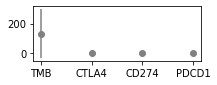

In [62]:
fig = plt.figure(figsize=(3,1))
plt.errorbar(x=df_plot.gene.tolist(),y=df_plot["mean"].tolist(),yerr=df_plot["std"].tolist(),fmt="o",color="gray")
plt.savefig("../plots/fig5/io.error.pdf")

### Get association of CTSS variant with RNA

In [24]:
raw=pd.read_csv("../data/icb-genotypes/all.time.raw",delim_whitespace=True)
rna_pre=rna[~rna["time"].isin(["On"])]
raw_rna=pd.merge(raw,rna_pre,on="FID",how="left")
ciber=pd.read_csv("/cellar/controlled/dbgap-genetic/ICB/phenos/pheno.cibersortx.txt",delimiter="\t")
ciber["FID"]=ciber["FID"].str.split(".").str[0]

In [25]:
raw_rna=pd.merge(raw_rna,ciber,on="FID",how="left")

In [26]:
raw_rna[~raw_rna["Macrophages.M2"].isnull()]["study"].value_counts()

riaz        46
vanallen    39
miao        33
hugo        27
Name: study, dtype: int64

In [27]:
raw_rna["response"]=raw_rna["FID"].map(mp_response)
raw_rna=raw_rna.replace({"response": dict_response})

In [28]:
raw_rna["CTSS_snp"]=np.where(raw_rna["1:150958977:T:C_C"]>0,1,0)
raw_rna["CTSW_snp"]=np.where(raw_rna["11:65712413:G:A_A"]>0,1,0)
raw_rna["FAM216A_snp"]=np.where(raw_rna["12:110857324:C:T_T"]>0,1,0)
raw_rna["LYZ_snp"]=np.where(raw_rna["12:69794086:C:G_C"]>0,1,0)
raw_rna["C3AR1_snp"]=np.where(raw_rna["12:8210697:A:G_A"]>0,1,0)
raw_rna["DCTN5_snp"]=np.where(raw_rna["16:23621132:T:C_C"]>0,1,0)
raw_rna["DBNDD1_snp"]=np.where(raw_rna["16:90080852:C:T_T"]>0,1,0)
raw_rna["FPR1_snp"]=np.where(raw_rna["19:52249702:G:T_T"]>0,1,0)
raw_rna["TREX1_snp"]=np.where(raw_rna["3:47587905:A:G_A"]>0,1,0)
raw_rna["DHFR_snp"]=np.where(raw_rna["5:80279422:T:G_T"]>0,1,0)
raw_rna["ERAP1_snp"]=np.where(raw_rna["5:96103589:G:A_A"]>0,1,0)
raw_rna["ERAP2_snp"]=np.where(raw_rna["5:96229542:T:G_G"]>0,1,0)
raw_rna["DYNLT1_snp"]=np.where(raw_rna["6:159050889:C:T_T"]>0,1,0)
raw_rna["GPLD1_snp"]=np.where(raw_rna["6:24560002:A:T_T"]>0,1,0)
raw_rna["PSMD11_snp"]=np.where(raw_rna["9:34549235:C:G_G"]>0,1,0)

In [29]:
def plot_snp(df,snp_lst,gene_lst):
    
    for snp in snp_lst:
    
        for gene in gene_lst:
        
            if snp.rsplit("_")[0]==gene:
                
                fig = plt.figure(figsize=(5,5))
                ax=sns.boxplot(x="study",y=gene,hue=snp,data=raw_rna)
        
                #get p-values
                labels=[item.get_text() for item in ax.get_xticklabels()]

                new_labels=[]
                for x in labels:
                    raw_rna_study=raw_rna[raw_rna["study"]==x]
                    cat0 = raw_rna_study[raw_rna_study[snp]==0]
                    cat1 = raw_rna_study[raw_rna_study[snp]!=0]
                    p=mannwhitneyu(cat0[gene], cat1[gene])[1]
                    new_labels.append(x+"\n{0:.4f}".format(p))
                ax.set_xticklabels(new_labels)
            
                plt.savefig("../plots/"+snp+"."+gene+".pdf")
        

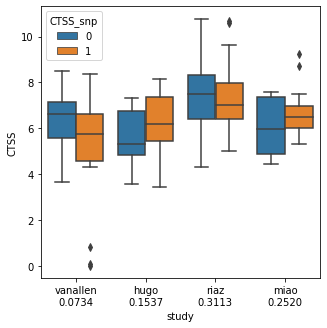

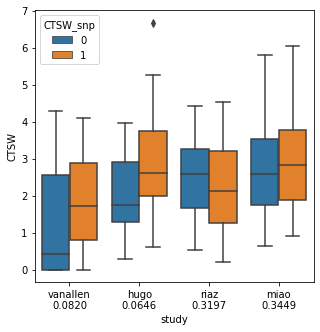

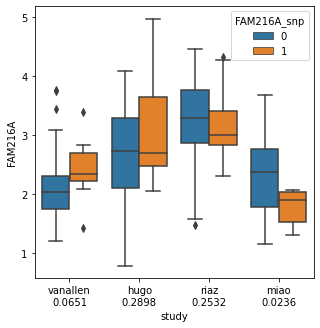

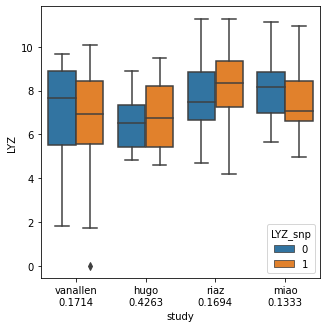

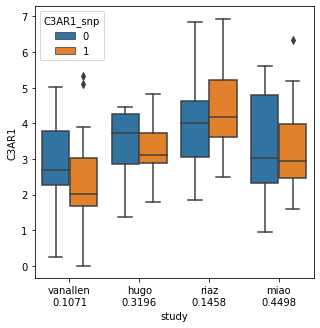

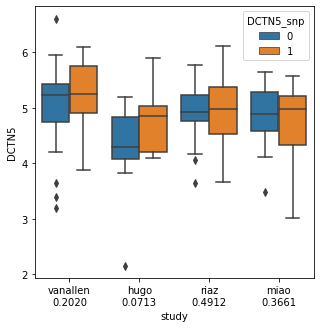

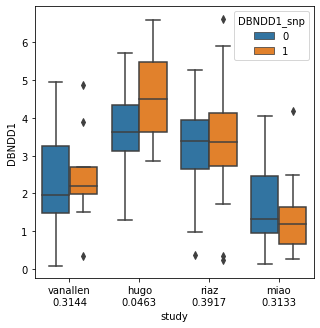

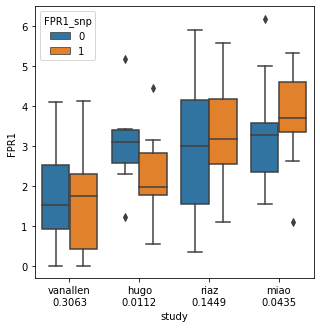

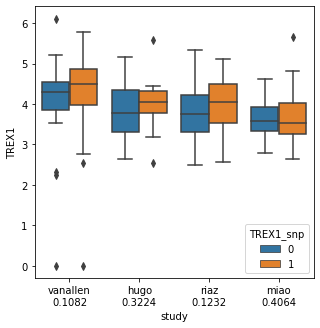

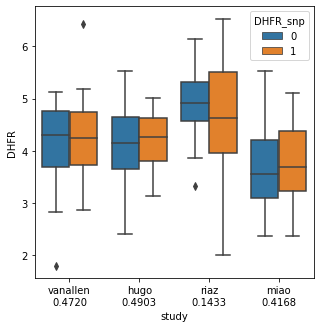

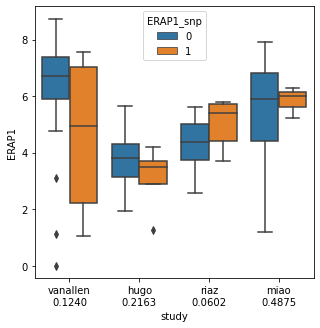

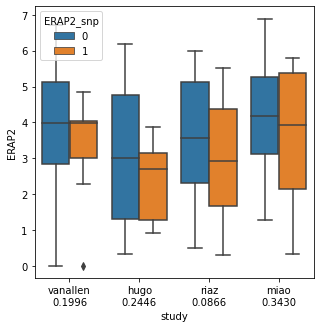

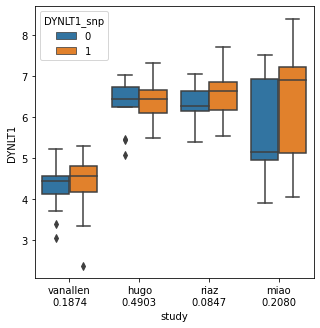

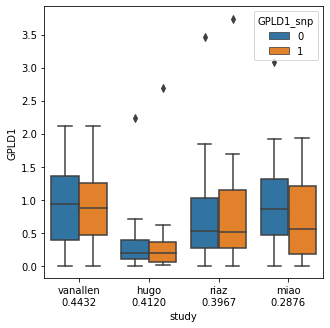

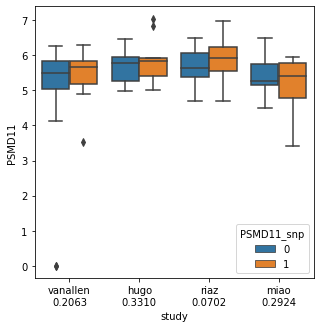

In [30]:
plot_snp(raw_rna,["CTSS_snp","CTSW_snp","FAM216A_snp","LYZ_snp","C3AR1_snp","DCTN5_snp","DBNDD1_snp","FPR1_snp","TREX1_snp","DHFR_snp","ERAP1_snp","ERAP2_snp","DYNLT1_snp","GPLD1_snp","PSMD11_snp"],["CTSS","CTSW","FAM216A","LYZ","C3AR1","DCTN5","DBNDD1","FPR1","TREX1","DHFR","ERAP1","ERAP2","DYNLT1","GPLD1","PSMD11"])

In [31]:
raw_rna["M1_M2+M0"]=raw_rna["Macrophages.M1"]/(raw_rna["Macrophages.M2"]+raw_rna["Macrophages.M0"])

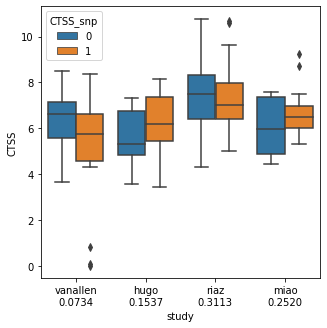

In [32]:
plot_snp(raw_rna,["CTSS_snp"],["CTSS","Macrophages.M0","Macrophages.M1","Macrophages.M2","M1.M2","M1_M2+M0"])

### Get association of TREX1 variant with RNA

In [33]:
raw_rna["3:47587905:A:G_A_snp"]=np.where(raw_rna["3:47587905:A:G_A"]>0,1,0)
raw_rna["3:48591481:C:T_C_snp"]=np.where(raw_rna["3:48591481:C:T_C"]>0,1,0)

In [34]:
plot_snp(raw_rna,["3:47587905:A:G_A_snp","3:48591481:C:T_C_snp"],["TREX1"])

### Get if SNPs are associated with increased expression

In [35]:
supp=pd.read_csv("../tables/supplementary_table_14.csv")
supp_sig=supp[supp["fdr"]<0.5]

In [36]:
for i, row in supp_sig.iterrows():
    col=[x for x in raw_rna.columns if row["MarkerName"] in x][0]
    raw_rna[col+"_snp"]=np.where(raw_rna[col]>0,1,0)
    try:
        plot_snp(raw_rna,[col+"_snp"],[row["file"]])
    except:
        pass

### Get RNA associations

In [37]:
assoc=pd.read_csv("../tables/ICB_associations.csv")
icb_snps=assoc["Variant"].tolist()+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in assoc["Variant"]]

In [38]:
rna_dir="../data/icb-rna-associations/"

rna_assoc=pd.DataFrame()

for x in [x for x in os.listdir(rna_dir) if "linear" in x]:
    rna=pd.read_csv(rna_dir+x,delimiter="\t")
    rna["file"]=x.split(".")[1]
    rna["cohort"]=x.split(".")[0]
    rna_assoc=rna_assoc.append(rna)

rna_assoc=rna_assoc[rna_assoc["TEST"]=="ADD"].sort_values(by="P")

In [39]:
assoc_dir="../data/icb-response/metal/input/response_crist_sd/"
compiled_icb=pd.DataFrame()

for file in [x for x in os.listdir(assoc_dir) if "add" in x]:
    print(file)
    icb=pd.read_csv(assoc_dir+file,delimiter="\t")
    icb=icb[icb["ID"].isin(icb_snps)]
    icb=fdr(icb,False,"P")
    icb["file"]=file
    compiled_icb=compiled_icb.append(icb)

vanallen.assoc.logistic.add
crist_hnscc.assoc.logistic.add
hugo.assoc.logistic.add
liu.assoc.logistic.add
riaz.assoc.logistic.add
crist_melanoma.assoc.logistic.add
snyder.assoc.logistic.add
rizvi.assoc.logistic.add
miao.assoc.logistic.add


In [40]:
compiled_icb["file"]=compiled_icb["file"].str.split(".").str[0]

In [41]:
val_lst=[]

for i,row in assoc.iterrows():
    print(row["Phenotype"])
    
    df_rna=rna_assoc[rna_assoc["ID"].isin([row["Variant"],row["Variant"].rsplit(":",2)[0]+":"+row["Variant"].split(":")[3]+":"+row["Variant"].split(":")[2]])]
    df_rna=df_rna[df_rna["file"]==row["Phenotype"]]
    df_icb=compiled_icb[compiled_icb["ID"].isin([row["Variant"],row["Variant"].rsplit(":",2)[0]+":"+row["Variant"].split(":")[3]+":"+row["Variant"].split(":")[2]])]
    
    if df_rna["A1"].tolist()[0] != df_icb["A1"].tolist()[0]:
        print("switching beta")
        df_rna["BETA"]=df_rna["BETA"]*-1
    
    val=[]
    
    for cohort in ["miao","riaz","vanallen","hugo"]:
        df_rna_cohort=df_rna[df_rna["cohort"]==cohort]["BETA"].tolist()[0]
        df_icb_cohort=df_icb[df_icb["file"]==cohort]["OR"].tolist()[0]
        if df_rna_cohort < 0:
            if df_icb_cohort > 1:
                val.append("+")
            if df_icb_cohort < 1:
                val.append("-")
        if df_rna_cohort > 0:
            if df_icb_cohort > 1:
                val.append("-")
            if df_icb_cohort < 1:
                val.append("+")
    val_lst.append("".join(val))

CTSS
CTSW
switching beta
FAM216A
LYZ
C3AR1
DCTN5
DBNDD1
FPR1
TREX1
DHFR
ERAP1
ERAP2
DYNLT1
GPLD1
PSMD11


In [42]:
assoc["potential"]=val_lst

### Check association with immunotherapy biomarkers

In [52]:
rna_dir="../data/icb-rna-associations/"

rna_assoc=pd.DataFrame()

files=[x for x in os.listdir(rna_dir) if "linear" in x]
files=[x for x in files if "melanoma" in x]

for x in files:
    rna=pd.read_csv(rna_dir+x,delimiter="\t")
    rna["file"]=x
    rna_assoc=rna_assoc.append(rna)

rna_assoc=rna_assoc[rna_assoc["TEST"]=="ADD"].sort_values(by="P")
rna_assoc["file"]=rna_assoc["file"].str.split(".").str[4]

In [53]:
rna_io=rna_assoc[rna_assoc["file"].isin(["TMB","PDCD1","CD274","CTLA4"])]
rna_io["-log10p"]=-np.log10(rna_io["P"])
rna_io["index"]=rna_io["file"].map({"TMB":3,"PDCD1":2,"CD274":1,"CTLA4":1})
rna_io=rna_io.sort_values(by=["#CHROM","POS","index"])

/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/cellar/users/tsears/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [54]:
snps=pd.read_csv("../tables/mega_snp_table_LASSO.txt",delimiter="\t")
icb_snps=snps[snps["icb_filt"]=="yes"]["snps"].tolist()
icb_snps=icb_snps+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in icb_snps]
rna_io=rna_io[rna_io["ID"].isin(icb_snps)]

In [50]:
rna_io

,#CHROM,POS,ID,REF,ALT,A1,TEST,OBS_CT,BETA,SE,T_STAT,P,ERRCODE,file,cohort,-log10p,index,fdr,-log10(fdr)
0,1,150527294,1:150527294:C:T,C,T,T,ADD,26,-1.617720,0.673193,-2.403050,0.033333,.,CTLA4,hugo,1.477132,1,0.877093,0.056954
0,1,150527294,1:150527294:C:T,C,T,T,ADD,46,-0.249867,0.250475,-0.997572,0.325971,.,CTLA4,riaz,0.486821,1,0.987493,0.005466
0,1,150527294,1:150527294:C:T,C,T,T,ADD,39,0.240890,0.282077,0.853984,0.401223,.,CD274,vanallen,0.396614,1,0.987493,0.005466
0,1,150527294,1:150527294:C:T,C,T,T,ADD,33,-0.127898,0.321684,-0.397590,0.695364,.,CTLA4,miao,0.157788,1,0.987493,0.005466
0,1,150527294,1:150527294:C:T,C,T,T,ADD,39,0.092582,0.259883,0.356244,0.724647,.,CTLA4,vanallen,0.139874,1,0.987493,0.005466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,19,52249702,19:52249702:G:T,G,T,T,ADD,53,68.164300,46.419700,1.468440,0.150006,.,TMB,snyder,0.823891,3,0.987493,0.005466
403,19,52249702,19:52249702:G:T,G,T,T,ADD,55,-4.317720,5.599120,-0.771142,0.445044,.,TMB,miao,0.351597,3,0.987493,0.005466
403,19,52249702,19:52249702:G:T,G,T,T,ADD,30,-21.756500,33.541100,-0.648653,0.525764,.,TMB,rizvi,0.279209,3,0.987493,0.005466
403,19,52249702,19:52249702:G:T,G,T,T,ADD,38,54.108500,150.970000,0.358407,0.723172,.,TMB,hugo,0.140758,3,0.987493,0.005466


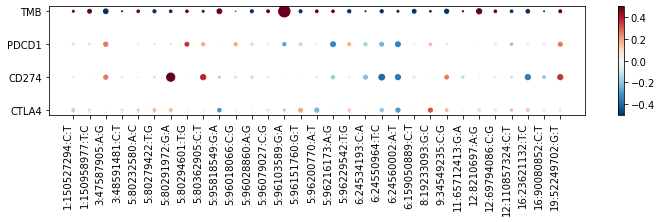

In [57]:
#Plot

#Plot

def heatmap(x, y, size, color):
    fig, ax = plt.subplots(figsize=(12, 2))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in x.unique()]
    y_labels = [v for v in y.unique()]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 20
    plt.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, 
        c=color,
        cmap="RdBu_r", vmin=-.5, vmax=.5# Vector of square sizes, proportional to size parameter
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    plt.colorbar()
    
    plt.xticks(rotation=90)
    
heatmap(
    x=rna_io['ID'],
    y=rna_io['file'],
    size=rna_io['-log10p'],
    color=rna_io['BETA'],
)

# 